In [1]:
import yake
import sys
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import requests
import time
from IPy import IP
from collections import defaultdict
import itertools  #used to slice a dictionary
import networkx as nx #networkx library for graph creation and clustering
import matplotlib.pyplot as plt  

In [2]:
#initialising our graph of keywords
graph_keywords = nx.Graph()

In [3]:
#Functions used for extraction of text from the url provided

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

def text_from_title(body):
    soup = BeautifulSoup(body, 'html.parser')
    title_text = soup.find('title').text
    return title_text

In [4]:
def community_layout(g, partition):
    # Compute the layout for a modular graph.
    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

In [5]:
def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

In [6]:
def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

In [7]:
def _position_nodes(g, partition, **kwargs):

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [8]:
skip_domains = [
    'www.mail.google.com',
    'www.mail.yahoo.com',
    'www.account.google.com',
    'www.facebook.com',  
    'www.docs.google.com'
]

def isIP(str):
    try:
        IP(str)
    except ValueError:
        return False
    return True

def generate_clean_urls():
    url_file = open('urls.txt', 'r')
    clean_urls = open('cleanUrls.txt', 'w')
    for url in url_file.readlines():
        url = url.strip()
        spltAr = url.split("://");
        protocol = spltAr[0]
        if protocol not in ['http', 'https']:
            continue
        i = (0,1)[len(spltAr)>1];
        dm = spltAr[i].split("?")[0].split('/')[0].split(':')[0].lower();
        if dm[0:4] != 'www.':
            # check if domain is ip address
            if isIP(dm):
                continue
            dm = 'www.' + dm
        # domain checks
        if dm in skip_domains:
            continue
        clean_urls.write(url+'\n')
    url_file.close()
    clean_urls.close()

In [9]:
def keywordExtractor(url):
    url = url.strip()
    headers={'User-Agent': 'Mozilla/5.0'}
    resp = requests.get(url, headers=headers, timeout=3) 
    if resp.status_code >= 300:
        return
    html = resp.text
    text = text_from_html(html)
    title_text = text_from_title(html).lower()
    max_ngram_size = 1
    simple_kwextractor = yake.KeywordExtractor(lan="en", n = max_ngram_size, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=20, features=None)
    keywords = simple_kwextractor.extract_keywords(text)
    title_keywords = simple_kwextractor.extract_keywords(title_text)
    title_words = dict([(t[1], t[0]) for t in title_keywords])  #to swap the term and its score to get {term:score}
    title_words = title_words.keys()
    
    keywords2 = []
    for kw in keywords:
        #since the order of term and score is reversed
        if kw[1] in title_words:
            kw2 = (kw[0]/4, kw[1])
        else:
            kw2 = kw
        keywords2.append(kw2)   #should be inside for loop so that all words are appended
    keywords2 = dict([(t[1], t[0]) for t in keywords2]) #to make a dictionary(as given in description) and also to reverse the order to {term:score}
    return keywords2

In [10]:
generate_clean_urls()

In [11]:
#We extract 5 most important keywords from each url and add those as nodes in our graph with an edge existing for
#every pair of keywords that co-occurs in a webpage.

i = 0
start_time = time.time()

#to store keywords and the urls they are present in
keywords_dict = {}

url_file = open('cleanUrls.txt', 'r')

for line in url_file.readlines():
    i += 1
    temp_dict = {}
    try:
        keywords = keywordExtractor(line)
        for kw in keywords:
            temp_dict[kw] = 1/keywords[kw]
        temp_dict = dict(sorted(temp_dict.items(), key=lambda x: x[1], reverse = True))
        temp_dict = dict(itertools.islice(temp_dict.items(), 5))  #to take only the top 5
        for w in temp_dict:
            if w in keywords_dict.keys():
                keywords_dict[w].append(line)
            else:
                keywords_dict[w] = [line]
                
        graph_keywords.add_nodes_from(temp_dict.keys())
                
        for word_i in temp_dict.keys() :
            for word_j in temp_dict.keys():
                if word_j != word_i:
                    graph_keywords.add_edge(word_i, word_j)
        
    except:
        continue

url_file.close()
end_time = time.time()

In [12]:
for i in keywords_dict.keys():
    print(i, end= ":\n")
    for ii in keywords_dict[i]:
        print(ii)

python:
https://www.python.org/

https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

python.org:
https://www.python.org/

events:
https://www.python.org/

community:
https://www.python.org/

software:
https://www.python.org/

ultimate:
https://en.wikipedia.org/wiki/Ultimate_(sport)

disc:
https://en.wikipedia.org/wiki/Ultimate_(sport)

retrieved:
https://en.wikipedia.org/wiki/Ultimate_(sport)

https://en.wikipedia.org/wiki/Tennis

frisbee:
https://en.wikipedia.org/wiki/Ultimate_(sport)

sport:
https://en.wikipedia.org/wiki/Ultimate_(sport)

learning:
https://towardsdatascience.com/machine-learning-an-introduction-23b84d51e6d0

https://machinelearningmastery.com/what-is-deep-learning/

machine:
https://towardsdatascience.com/machine-learning-an-introduction-23b84d51e6d0

data:
https://towardsdatascience.com/machine-learning-an-introduction-23b84d51e6d0

science:
https://towardsdatascience.com/machine-learning-an-introduction-23b84d51e6d0

unsupervised:
https://t

In [13]:
print('time taken : ')
print(end_time - start_time)
print('url processed : ')
print(i)

time taken : 
17.08391809463501
url processed : 
file


In [14]:
graph_keywords.nodes()

NodeView(('python', 'python.org', 'events', 'community', 'software', 'ultimate', 'disc', 'retrieved', 'frisbee', 'sport', 'learning', 'machine', 'data', 'science', 'unsupervised', 'deep', 'jason', 'brownlee', 'reply', 'tennis', 'players', 'player', 'game', 'file'))

In [15]:
#from networkx.algorithms import community
import community

clusters = community.best_partition(graph_keywords)
pos = community_layout(graph_keywords, clusters)

/home/ashutosh/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


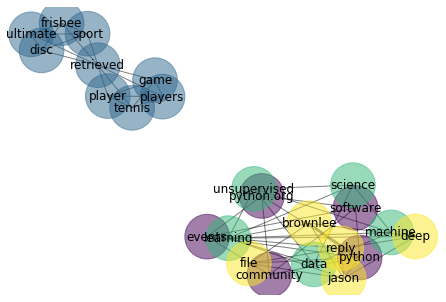

In [16]:
nx.draw(graph_keywords, pos, node_color=list(clusters.values()), node_size=2000, alpha = 0.5)

labels = {}
for word in keywords_dict.keys():
    labels[word] = word
nx.draw_networkx_labels(graph_keywords, pos, labels)

plt.show()

We can see that the keywords related to machine learning/deep learning/python were clustered together and the keywords related to sports (Ultimate frisbee and tennis) were clustered together.